<div align="center">

# Steerable discovery of neural audio effects

  [Christian J. Steinmetz](https://www.christiansteinmetz.com/)  and  [Joshua D. Reiss](http://www.eecs.qmul.ac.uk/~josh/)


[Code](https://github.com/csteinmetz1/steerable-nafx) • [Paper](https://arxiv.org/abs/2112.02926) • [Demo](https://csteinmetz1.github.io/steerable-nafx)	• [Slides]()

<img src="https://csteinmetz1.github.io/steerable-nafx/assets/steerable-headline.svg">

</div>

## Abtract
Applications of deep learning for audio effects often focus on modeling analog effects or learning to control effects to emulate a trained audio engineer. 
However, deep learning approaches also have the potential to expand creativity through neural audio effects that enable new sound transformations. 
While recent work demonstrated that neural networks with random weights produce compelling audio effects, control of these effects is limited and unintuitive.
To address this, we introduce a method for the steerable discovery of neural audio effects.
This method enables the design of effects using example recordings provided by the user. 
We demonstrate how this method produces an effect similar to the target effect, along with interesting inaccuracies, while also providing perceptually relevant controls.


\* *Accepted to NeurIPS 2021 Workshop on Machine Learning for Creativity and Design*



# Setup

In [1]:
import numpy as np
import scipy.signal

import torch
import torchaudio
import torchinfo
import onnx

import os
import IPython
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import librosa.display

### Choose computation device

In [2]:
if torch.cuda.is_available():
  device = "cuda"
else:
  device = "cpu"

In [3]:
name = 'model_0'


if not os.path.exists('models/'+name):
    os.makedirs('models/'+name)
else:
    print("A model with the same name already exists. Please choose a new name.")
    exit

A model with the same name already exists. Please choose a new name.


In [4]:
class TCNBlock(torch.nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size, dilation, activation=True):
    super().__init__()
    self.conv = torch.nn.Conv1d(
        in_channels, 
        out_channels, 
        kernel_size, 
        dilation=dilation, 
        padding=0, #((kernel_size-1)//2)*dilation,
        bias=True)
    if activation:
      #self.act = torch.nn.Tanh()
      self.act = torch.nn.PReLU()
    # this is the residual connection with 1x1 conv to match the channels and mix the desired amount of residual in
    self.res = torch.nn.Conv1d(in_channels, out_channels, 1, bias=False)
    self.kernel_size = kernel_size
    self.dilation = dilation

  def forward(self, x):
    x_in = x
    x = self.conv(x)
    if hasattr(self, "act"):
      x = self.act(x)
    x_res = self.res(x_in)
    x_res = x_res[..., (self.kernel_size-1)*self.dilation:]
    x = x + x_res

    return x

class TCN(torch.nn.Module):
  def __init__(self, n_inputs=1, n_outputs=1, n_blocks=10, kernel_size=13, n_channels=64, dilation_growth=4):
    super().__init__()
    self.kernel_size = kernel_size
    self.n_channels = n_channels
    self.dilation_growth = dilation_growth
    self.n_blocks = n_blocks
    self.stack_size = n_blocks

    self.blocks = torch.nn.ModuleList()
    for n in range(n_blocks):
      if n == 0:
        in_ch = n_inputs
        out_ch = n_channels
        act = True
      elif (n+1) == n_blocks:
        in_ch = n_channels
        out_ch = n_outputs
        act = True
      else:
        in_ch = n_channels
        out_ch = n_channels
        act = True
      
      dilation = dilation_growth ** n
      self.blocks.append(TCNBlock(in_ch, out_ch, kernel_size, dilation, activation=act))

  def forward(self, x):
    for block in self.blocks:
      x = block(x)
    return x
  
  def compute_receptive_field(self):
    """Compute the receptive field in samples."""
    rf = self.kernel_size
    for n in range(1, self.n_blocks):
        dilation = self.dilation_growth ** (n % self.stack_size)
        rf = rf + ((self.kernel_size - 1) * dilation)
    return rf

# 1. Steering (training)
Use a pair of audio examples in order to construct neural audio effects.

There are two options. Either start with the pre-loaded audio examples, or upload your own clean/processed audio recordings for the steering process.

a.) Use some of our pre-loaded audio examples. Choose from the compressor or reverb effect.

In [5]:
#@title Use pre-loaded audio examples for steering
effect_type = "Reverb" #@param ["Compressor", "Reverb"]

if effect_type == "Compressor":
  input_file = "audio/drum_kit_clean.wav"
  output_file = "audio/drum_kit_comp_agg.wav"
elif effect_type == "Reverb":
  input_file = "audio/acgtr_clean.wav"
  output_file = "audio/acgtr_reverb.wav"

x, sample_rate = torchaudio.load(input_file)
y, sample_rate = torchaudio.load(output_file)

x = x[0:1,:]
y = y[0:1,:]

print("x shape", x.shape)
print(f"x = {x}")
print("y shape", y.shape)
print(f"y = {y}")

print("input file", x.shape)
IPython.display.display(IPython.display.Audio(data=x, rate=sample_rate))
print("output file", y.shape)
IPython.display.display(IPython.display.Audio(data=y, rate=sample_rate))

x shape torch.Size([1, 508032])
x = tensor([[-3.0518e-05, -3.0518e-05, -3.0518e-05,  ...,  9.3384e-03,
          2.8992e-03,  0.0000e+00]])
y shape torch.Size([1, 508032])
y = tensor([[-3.0518e-05,  0.0000e+00,  0.0000e+00,  ...,  7.4097e-02,
          7.7271e-02,  7.8522e-02]])
input file torch.Size([1, 508032])


output file torch.Size([1, 508032])


Now its time to generate the neural audio effect by training the TCN to emulate the input/output function from the target audio effect. Adjusting the parameters will enable you to tweak the optimization process. 

In [6]:
#@title TCN model training parameters
kernel_size = 13 #@param {type:"slider", min:3, max:32, step:1}
n_blocks = 4 #@param {type:"slider", min:2, max:30, step:1}
dilation_growth = 10 #@param {type:"slider", min:1, max:10, step:1}
n_channels = 32 #@param {type:"slider", min:1, max:128, step:1}
n_iters = 150 #@param {type:"slider", min:0, max:10000, step:1}
length = 228308 #@param {type:"slider", min:0, max:524288, step:1}
lr = 0.001 #@param {type:"number"}

# reshape the audio
x_batch = x.view(1,1,-1)
y_batch = y.view(1,1,-1)

print(f"x_batch shape: {x_batch.shape}")
print(f"y_batch shape: {y_batch.shape}")

# build the model
model = TCN(
    n_inputs=1,
    n_outputs=1,
    kernel_size=kernel_size, 
    n_blocks=n_blocks, 
    dilation_growth=dilation_growth, 
    n_channels=n_channels)
rf = model.compute_receptive_field()
params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Parameters: {params*1e-3:0.3f} k")
print(f"Receptive field: {rf} samples or {(rf/sample_rate)*1e3:0.1f} ms")

x_batch shape: torch.Size([1, 1, 508032])
y_batch shape: torch.Size([1, 1, 508032])
Parameters: 29.669 k
Receptive field: 13333 samples or 302.3 ms


In [7]:
# setup loss function, optimizer, and scheduler
loss_fn_mse = torch.nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr)
ms1 = int(n_iters * 0.8)
ms2 = int(n_iters * 0.95)
milestones = [ms1, ms2]
print(
    "Learning rate schedule:",
    f"1:{lr:0.2e} ->",
    f"{ms1}:{lr*0.1:0.2e} ->",
    f"{ms2}:{lr*0.01:0.2e}",
)
scheduler = torch.optim.lr_scheduler.MultiStepLR(
    optimizer,
    milestones,
    gamma=0.1,
    verbose=False,
)

summary = torchinfo.summary(model, (1, 1, 228308), device=device)
print(summary)

print("The reduction in the first layer is from the kernel size. The reduction in the subsequent layers is from the dilation factor and kernel size.")

Learning rate schedule: 1:1.00e-03 -> 120:1.00e-04 -> 142:1.00e-05
Layer (type:depth-idx)                   Output Shape              Param #
TCN                                      [1, 1, 214976]            --
├─ModuleList: 1-1                        --                        --
│    └─TCNBlock: 2-1                     [1, 32, 228296]           --
│    │    └─Conv1d: 3-1                  [1, 32, 228296]           448
│    │    └─PReLU: 3-2                   [1, 32, 228296]           1
│    │    └─Conv1d: 3-3                  [1, 32, 228308]           32
│    └─TCNBlock: 2-2                     [1, 32, 228176]           --
│    │    └─Conv1d: 3-4                  [1, 32, 228176]           13,344
│    │    └─PReLU: 3-5                   [1, 32, 228176]           1
│    │    └─Conv1d: 3-6                  [1, 32, 228296]           1,024
│    └─TCNBlock: 2-3                     [1, 32, 226976]           --
│    │    └─Conv1d: 3-7                  [1, 32, 226976]           13,344
│    │  

In [8]:
# move tensors to GPU
if torch.cuda.is_available():
  model.to(device)
  x_batch = x_batch.to(device)
  y_batch = y_batch.to(device)

start_idx = rf 
stop_idx = start_idx + length

# the data is the same with every iteration
x_crop = x_batch[...,start_idx-rf+1:stop_idx]
y_crop = y_batch[...,start_idx:stop_idx]

print(f"x_crop = {x_crop.shape}")
print(f"y_crop = {y_crop.shape}")

########## iteratively update the weights

# this is only for the progress bar
pbar = tqdm(range(n_iters))

for n in pbar:
  optimizer.zero_grad()

  y_hat = model(x_crop)
  loss = loss_fn_mse(y_hat, y_crop)

  loss.backward()
  optimizer.step()
  
  scheduler.step()
  if (n+1) % 1 == 0:
    pbar.set_description(f" Loss: {loss.item()} | ")

x_crop = torch.Size([1, 1, 241640])
y_crop = torch.Size([1, 1, 228308])


  0%|          | 0/150 [00:00<?, ?it/s]

In [9]:
torch.save(model.state_dict(), "models/"+name+"/"+name+".pth")

## Run predictions
### 0. Load the model

In [10]:
model.load_state_dict(torch.load("models/"+name+"/"+name+".pth", map_location=torch.device('cpu')))

<All keys matched successfully>

### 1. On the test audio data

Input shape: (508032,)
Output shape: (508032,)
Target shape: (508032,)
Input (clean)


Target


Output


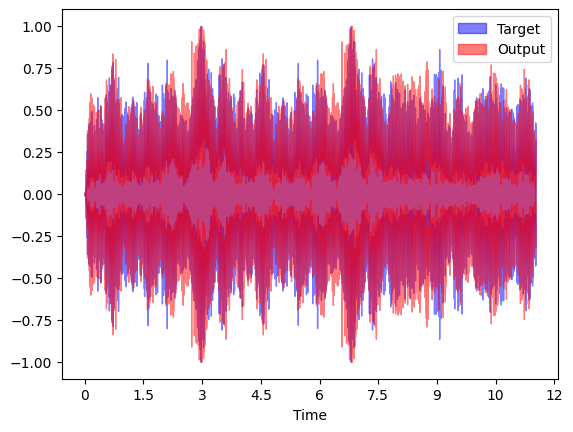

In [11]:
# Run Prediction #################################################
# Test the model on the testing data #############################

# needed because in the train we crop the target
x_pad = torch.nn.functional.pad(x_batch, (rf-1, 0))

model.eval()
with torch.no_grad():
  y_hat = model(x_pad)

input = x_batch.view(-1).detach().cpu().numpy()[-y_hat.shape[-1]:]
output = y_hat.view(-1).detach().cpu().numpy()
target = y_batch.view(-1).detach().cpu().numpy()

print(f"Input shape: {input.shape}")
print(f"Output shape: {output.shape}")
print(f"Target shape: {target.shape}")

# apply highpass to outpu to remove DC
sos = scipy.signal.butter(8, 20.0, fs=sample_rate, output="sos", btype="highpass")
output = scipy.signal.sosfilt(sos, output)

input /= np.max(np.abs(input))
output /= np.max(np.abs(output))
target /= np.max(np.abs(target))

fig, ax = plt.subplots(nrows=1, sharex=True)
librosa.display.waveshow(target, sr=sample_rate, color='b', alpha=0.5, ax=ax, label='Target')
librosa.display.waveshow(output, sr=sample_rate, color='r', alpha=0.5, ax=ax, label='Output')

print("Input (clean)")
IPython.display.display(IPython.display.Audio(data=input, rate=sample_rate))
print("Target")
IPython.display.display(IPython.display.Audio(data=target, rate=sample_rate))
print("Output")
IPython.display.display(IPython.display.Audio(data=output, rate=sample_rate))
plt.legend()
plt.show(fig)

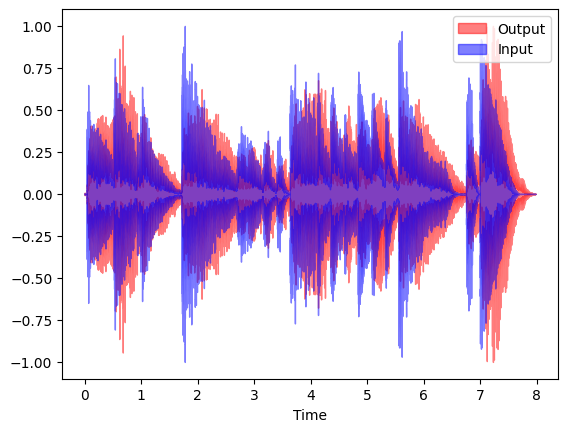

In [12]:
# Load and Preprocess Data ###########################################
x_whole, sample_rate = torchaudio.load("audio/piano_clean.wav")
x_whole = x_whole[0,:]
x_whole = x_whole.view(1,1,-1).to(device)

# Padding on both sides of the receptive field
x_whole = torch.nn.functional.pad(x_whole, (rf-1, rf-1))

with torch.no_grad():
  y_whole = model(x_whole)

x_whole = x_whole[..., -y_whole.shape[-1]:]

y_whole /= y_whole.abs().max()

# apply high pass filter to remove DC
sos = scipy.signal.butter(8, 20.0, fs=sample_rate, output="sos", btype="highpass")
y_whole = scipy.signal.sosfilt(sos, y_whole.cpu().view(-1).numpy())

x_whole = x_whole.view(-1).cpu().numpy()

y_whole = (y_whole * 0.8)
IPython.display.display(IPython.display.Audio(data=x_whole, rate=sample_rate))
IPython.display.display(IPython.display.Audio(data=y_whole, rate=sample_rate))

x_whole /= np.max(np.abs(x_whole))
y_whole /= np.max(np.abs(y_whole))

fig, ax = plt.subplots(nrows=1, sharex=True)
librosa.display.waveshow(y_whole, sr=sample_rate, color='r', alpha=0.5, ax=ax, label='Output')
librosa.display.waveshow(x_whole, sr=sample_rate, alpha=0.5, ax=ax, label='Input', color="blue")
plt.legend()
plt.show(fig)


### 2. On a number sequence (to control inference)

In [17]:
# Test the model simple number sequence to compare with inference #
X_testing_2 = np.array([])

for i in range(0, 2048+rf-1):
    X_testing_2 = np.append(X_testing_2, i*0.000001)

X_testing_2 = torch.from_numpy(X_testing_2).view(1,1,-1)

print("Running prediction..")
prediction_2 = model(X_testing_2.to(device).float())

print(f"prediction {prediction_2}")

print("X_testing_2 shape: ", X_testing_2.shape)
print("prediction_2 shape: ", prediction_2.shape)

Running prediction..
prediction tensor([[[0.0009, 0.0009, 0.0009,  ..., 0.0015, 0.0015, 0.0015]]],
       grad_fn=<AddBackward0>)
X_testing_2 shape:  torch.Size([1, 1, 15380])
prediction_2 shape:  torch.Size([1, 1, 2048])


# Export as pt and onnx model

In [14]:
# torch.save(model, "models/"+name+"/"+name+".pt") todo does this work?

In [15]:
buffer_size = 2048
# rf is the receptive field and hence the kernel size of the last layer because of the dilation
# hence the model input size needs to be at least rf
model_input_size = buffer_size+rf-1

# An example input you would normally provide to your model's forward() method.
example_x = torch.rand(1, 1, model_input_size).to(device)

# Use torch.jit.trace to generate a torch.jit.ScriptModule via tracing.
traced_script_module = torch.jit.trace(model, example_inputs=example_x)
traced_script_module.save("models/"+name+"/"+"steerable-nafx.pt")

In [16]:
buffer_size = 2048
# rf is the receptive field and hence the kernel size of the last layer because of the dilation
# hence the model input size needs to be at least rf
model_input_size = buffer_size+rf-1

# An example input you would normally provide to your model's forward() method.
example_x = torch.rand(1, 1, model_input_size).to(device)

filepath = "models/"+name+"/"+"steerable-nafx-libtorch"+".onnx"

# Export the model
torch.onnx.export(model=model,
                  args=example_x,
                  f=filepath,
                  export_params=True,
                  opset_version=13,
                  do_constant_folding=True,
                  input_names = ['input'],
                  output_names = ['output'])